In [ ]:
# !mkdir data
# %cd data

In [ ]:
# !wget https://raw.githubusercontent.com/lablnet/covid19/main/analysis/dailyStats.csv
# %cd ..

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('data/dailyStats.csv',parse_dates=['datetime'],index_col='datetime')
df.head()

,sr#,new_cases,
datetime,,,
2020-03-17,1,25,NaN
2020-02-26,2,1,NaN
2020-03-15,3,2,NaN
2020-03-18,4,9,NaN
2020-03-14,5,1,NaN


In [95]:
df.isna().sum()

sr#            0
new_cases      0
             896
dtype: int64

In [3]:
df.drop(['sr# '], axis=1, inplace=True)
#remove column wih null values
df = df[df.columns[~df.isnull().all()]]
df

,new_cases
datetime,
2020-03-17,25
2020-02-26,1
2020-03-15,2
2020-03-18,9
2020-03-14,1
...,...
2022-08-18,509
2022-08-19,450
2022-08-21,808


<AxesSubplot:xlabel='datetime'>

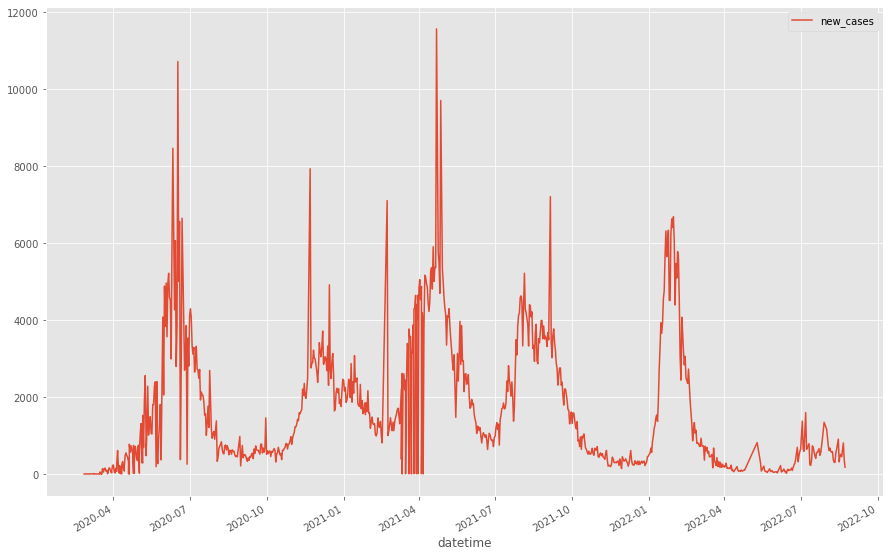

In [97]:
df.plot(figsize=(15,10))

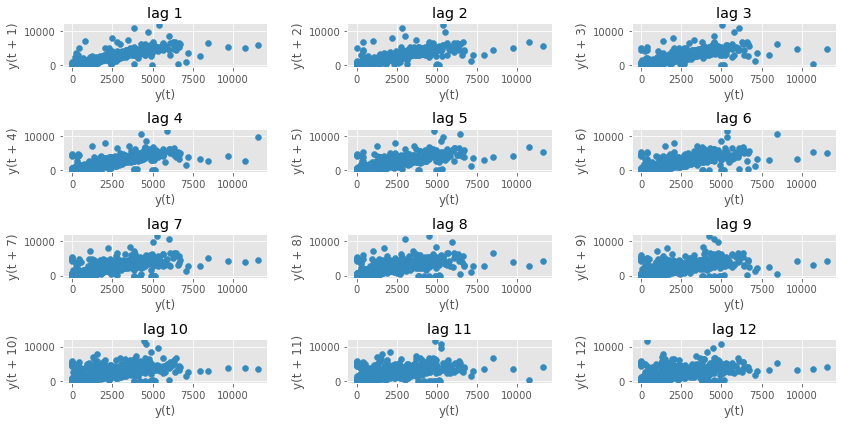

In [98]:
# lag plot
fig = plt.figure(figsize=(12,6))
for i in range(1,13):
    ax = fig.add_subplot(4,3,i)
    ax.set_title('lag '+str(i))
    pd.plotting.lag_plot(df['new_cases'], lag=i)
    plt.tight_layout()
    

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

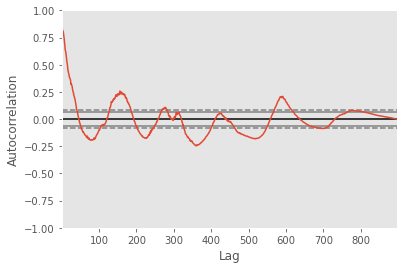

In [99]:
# acf plot
pd.plotting.autocorrelation_plot(df['new_cases'])

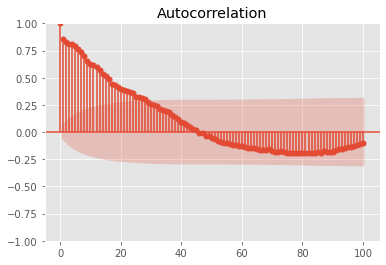

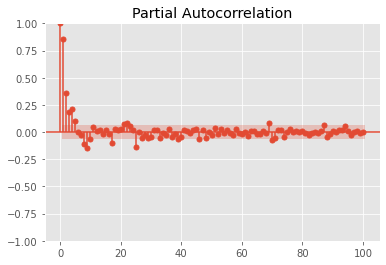

In [100]:
# plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['new_cases'], lags=100)
plot_pacf(df['new_cases'], lags=100)
plt.show()

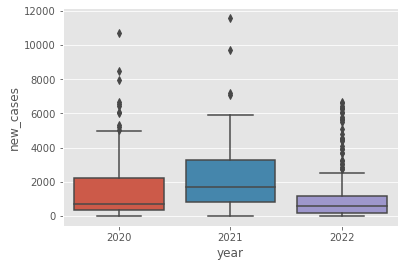

In [101]:
# yearly distribution
tmp = df.copy()
tmp['year'] = tmp.index.year
sns.boxplot(x='year', y='new_cases', data=tmp)
plt.show()

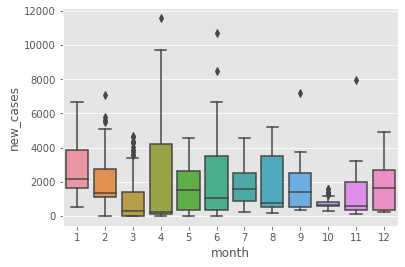

In [102]:
# monthly distribution
tmp = df.copy()
tmp['month'] = tmp.index.month
sns.boxplot(x='month', y='new_cases', data=tmp)
plt.show()


<AxesSubplot:xlabel='month', ylabel='new_cases'>

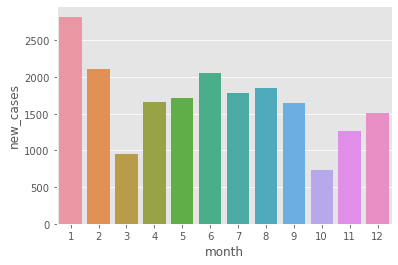

In [5]:
# monthlu cases
tmp = df.copy()
tmp['month'] = tmp.index.month
monthly_cases = tmp.groupby('month').mean()
monthly_cases['month'] = monthly_cases.index
# barplot
sns.barplot(x='month', y='new_cases', data=monthly_cases)

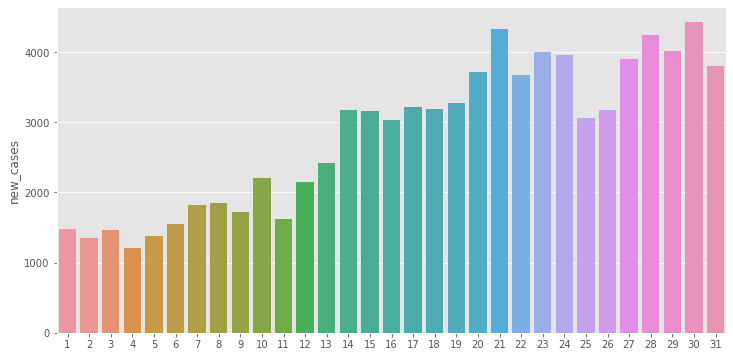

In [14]:
# zoom in on january
jan_cases = tmp[tmp.index.month == 1].groupby(lambda x: (x.day)).new_cases.mean()
plt.figure(figsize=(12,6))
sns.barplot(x=np.arange(1,len(jan_cases)+1), y=jan_cases)
plt.show()

<AxesSubplot:xlabel='datetime'>

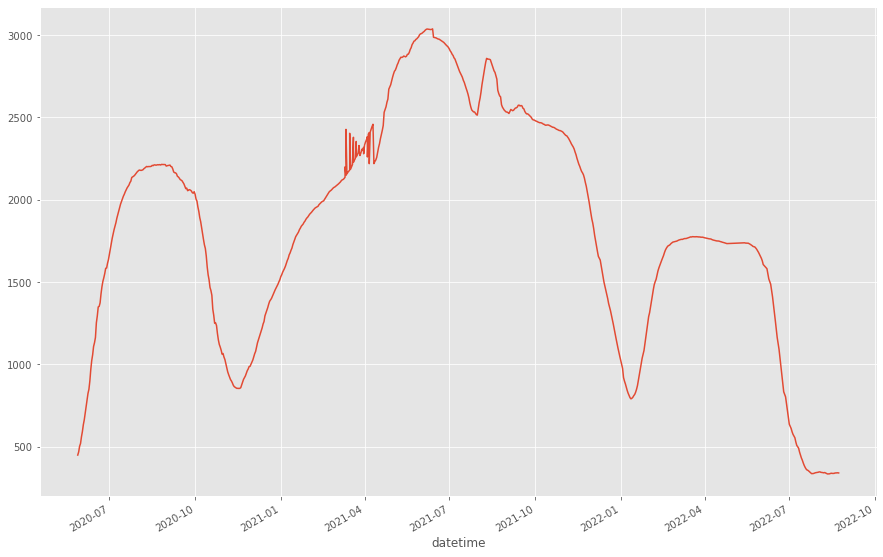

In [33]:
# rolling mean
df['new_cases'].rolling(120).mean().plot(figsize=(15,10))


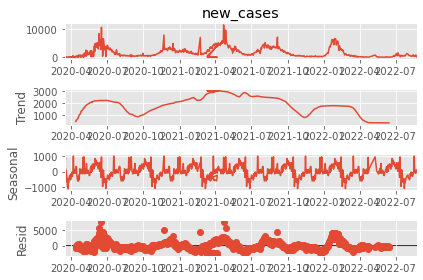

In [37]:
# seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['new_cases'], model='additive',period=120)

decompose.plot()
plt.show()

In [18]:
train = df[df.index < '2022-03-01']
test = df[df.index >= '2022-03-01']
print(train.shape, test.shape)

(755, 1) (141, 1)


Failure of simple regression. There are outliers in the data, i fit huber regression which is robust to outliers.



In [53]:
# linear regression
from sklearn.linear_model import HuberRegressor
tmp_train = train.copy()
tmp_train['time'] = np.arange(len(tmp_train))
tmp_test = test.copy()
tmp_test['time'] = tmp_train['time'].max() + np.arange(len(tmp_test))
X_train = tmp_train['time'].values.reshape(-1,1)
y_train = tmp_train['new_cases'].values.reshape(-1,1)
y_train = tmp_train['new_cases']
y_test = tmp_test['new_cases']
reg = HuberRegressor().fit(X_train, y_train)
# r2 
r2 = reg.score(X_train, y_train)
print("R2:", r2)

R2: 0.027911833963122912


In [59]:
# test_pred = reg.predict(tmp_test['time'].values.reshape(-1,1))
# test_pred = test_pred.reshape(-1,1)
# test_pred = pd.DataFrame(test_pred, index=tmp_test.index, columns=['new_cases'])
# test_pred.plot(figsize=(15,10), label='predicted')
# test['new_cases'].plot(figsize=(15,10), label='actual')
# plt.legend()

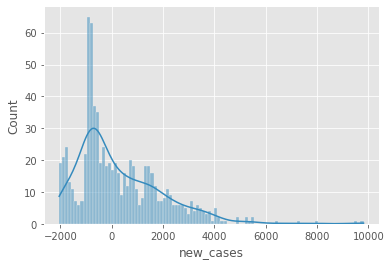

In [49]:
residuals = y_train - reg.predict(X_train)
# histogram of residuals
sns.histplot(residuals,kde=True,bins=100)
plt.show()

The distribution of residuals is skewed right.

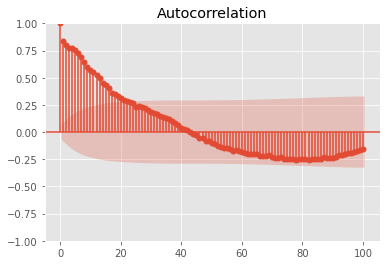

In [50]:
# acf of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=100)
plt.show()

In [51]:
# Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(residuals, lags=20)


,lb_stat,lb_pvalue
1,526.787022,1.412386e-116
2,1013.340805,9.033169e-221
3,1465.019264,0.000000e+00
4,1919.557955,0.000000e+00
5,2354.057753,0.000000e+00
6,2754.249158,0.000000e+00
7,3121.084569,0.000000e+00
8,3440.091913,0.000000e+00
9,3713.356317,0.000000e+00
10,3959.535734,0.000000e+00


Ljung-Box test shows that the residuals are not independent.

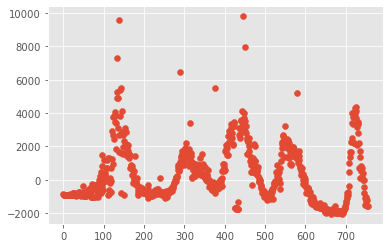

In [52]:
# Residual versus predictor
plt.scatter(X_train, residuals)
plt.show()

There is a clear pattern

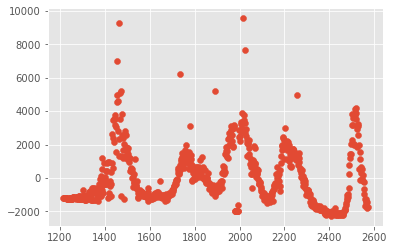

In [47]:
# residuals vs fitted values
plt.scatter(reg.predict(X_train), residuals)
plt.show()
